# Import

In [1]:
import time as time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import csv
import seaborn as sns
import os
import scipy.io
import scipy.stats
import pickle

import sys
sys.path.insert(1, '/Users/felicia/Documents/CFIN/ensembles_code') # change path here!
import assembly as assembly

# Load non-airpuff data

In [ ]:
"""
The script includes:
    -Marcenko-Pastur distribution
    -Average across reward/punishment trials for a NON-AIRPUFF session
    
---------
This code is based on:
    Lopes-dos-Santos, V., Ribeiro, S., & Tort, A. B. L. (2013). Detecting cell assemblies in large neuronal 
    populations. Journal of Neuroscience Methods, 220(2), 149–166. https://doi.org/10.1016/j.jneumeth.2013.04.010
    
Python 3.8.5

Dependencies:
    -numpy 1.19.2
    -pandas 1.1.3
    -scipy 1.6.3
    -matplotlib 3.3.2
    -seaborn 0.11.0
    -sklearn 0.0
    -sys, random, copy, csv, os, time, pickle
"""

In [2]:
#### change folder path here for each animal!
animal_folder_name = "/Users/felicia/Documents/CFIN/233/233_traces/"

In [3]:
#### change session number here
session = "06"

In [4]:
# load csv calcium traces
folder_name = "Calcium_Traces/"
filename = "2021-05-{0}.csv".format(session)
df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
n_rows, n_columns = df.shape

# create time array
df_times = df[' '][1:-1]
df_num_time = pd.to_numeric(df_times, downcast='float')
time_array = df_num_time.to_numpy()
tot_timepoints = len(time_array)

# check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
time_sampling = np.zeros(shape=(len(time_array)-1,))
for i in range(1,len(time_array)):
    time_sampling[i-1] = time_array[i]-time_array[i-1]

#12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
sampling_rate = 0.1
tot_secs = int(tot_timepoints * sampling_rate)

#create channels array
n_channels = n_columns-1
channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
# fill empty channels array
for i in range(n_channels):
    col_name = df.columns[i+1]
    df_channel = df[col_name][1:-1]
    df_num_channel = pd.to_numeric(df_channel, downcast='float')
    channels_array[:,i] = df_num_channel.to_numpy()
    
# load the behavioral data
#folder_name = "trial_info" #/no_airpuff"
#bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
#trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

# extract information from trial_info: in matlab this is a struct with the fields:
#trials_start_time = trial_info['trial_info'][0,0][0].ravel()
#trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
#trials_response = trial_info['trial_info'][0,0][2].ravel()
#trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
#trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
#trials_end_time = trial_info['trial_info'][0,0][5].ravel()
#trials_finish_reward = trial_info['trial_info'][0,0][6].ravel()
#n_trials = len(trials_end_time) # number of trials

# load behavioural data (.pkl file)
input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
     trial_info = pickle.load(fp)

# extract information for trial_info: in PYTHON
trials_start_time = np.array(trial_info['start_time'])
trials_stimulus_on = np.array(trial_info['stimulus_on'])
trials_response = np.array(trial_info['response'])
trials_is_right_lick = np.array(trial_info['is_right_lick'])
trials_is_reward = np.array(trial_info['is_reward'])
trials_end_time = np.array(trial_info['end_trial'])
n_trials = len(trials_end_time)

# 500msec between start and stimulus onset
new_start = [] # initiate empty list
new_end = [] # initiate empty list
new_start.append(trials_stimulus_on[0]-0.5) # append first start
new_end.append(trials_stimulus_on[1]-0.5) # append first end
for i in range(1,n_trials-1): # append start & end times for each trial (except last)
    new_start.append(trials_stimulus_on[i]-0.5)
    new_end.append(trials_stimulus_on[i+1]-0.5)
new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
new_end.append(trials_end_time[n_trials-1]) # append last end
new_start = np.array(new_start) # turn list to array
new_end = np.array(new_end)
n_trials = len(new_end)

# where was the stimulus? we don't have this info. But it can be reconstructed 
stimulus_reconstruction = np.zeros(shape=(n_trials,))
right_choice = np.where(trials_is_reward==1)[0]
stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
wrong_choice = np.where(trials_is_reward==0)[0]
stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

# split traces data into trials
X = {}
for i in range(n_trials-1):
    lower_bound = np.min(np.where(time_array>=new_start[i]))
    upper_bound = np.max(np.where(time_array<=new_end[i]))
    X[i] = channels_array[lower_bound:upper_bound,:]

# Marcenko-Pastur function as null distribution

Text(0.5, 0.98, 'Using MP distribution, elapsed time: 0.065 seconds')

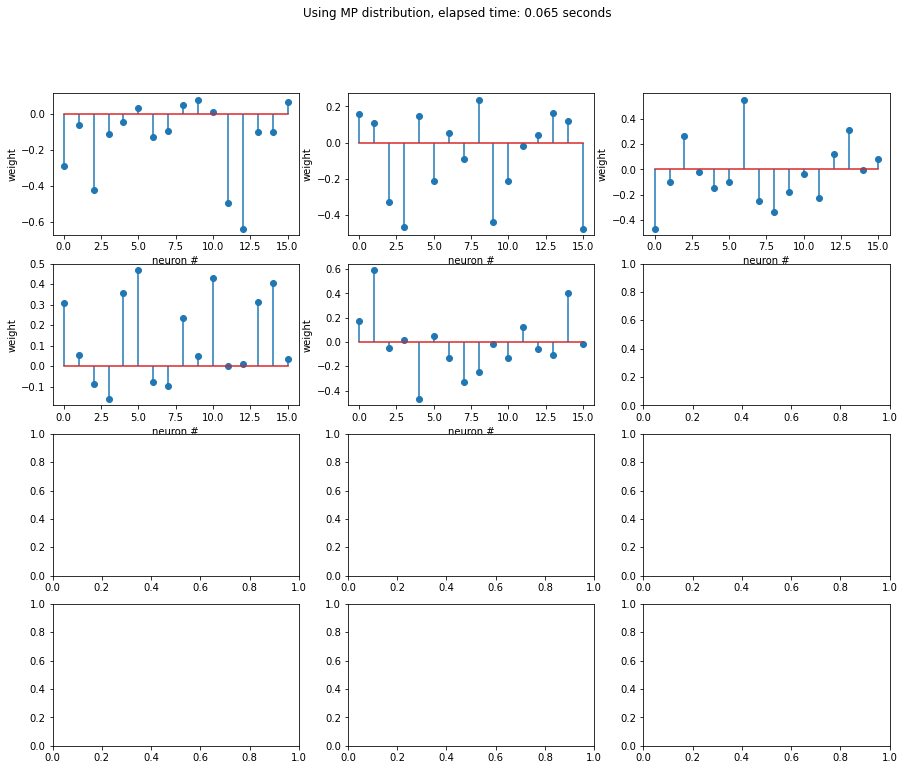

In [5]:
# using Marcenko-Pastur function as null distribution
actmat = np.transpose(channels_array) # [n_cells, n_timepoints]
t0 = time.time()
patterns,significance,zactmat = assembly.runPatterns(actmat,nullhyp='mp')
tf = np.round(1000*(time.time()-t0))/1000

fig, axs = plt.subplots(4,3, figsize=(15, 12))
axs = axs.ravel()

for (pi,pattern) in enumerate(patterns):
        axs[pi].stem(pattern)
        axs[pi].set_xlabel('neuron #')
        axs[pi].set_ylabel('weight')
fig.suptitle('Using MP distribution, elapsed time: '+str(tf)+' seconds')

# simple bin shuffling as null distribution

Text(0.5, 0.98, 'Using bin shuffling, elapsed time: 17.648 seconds')

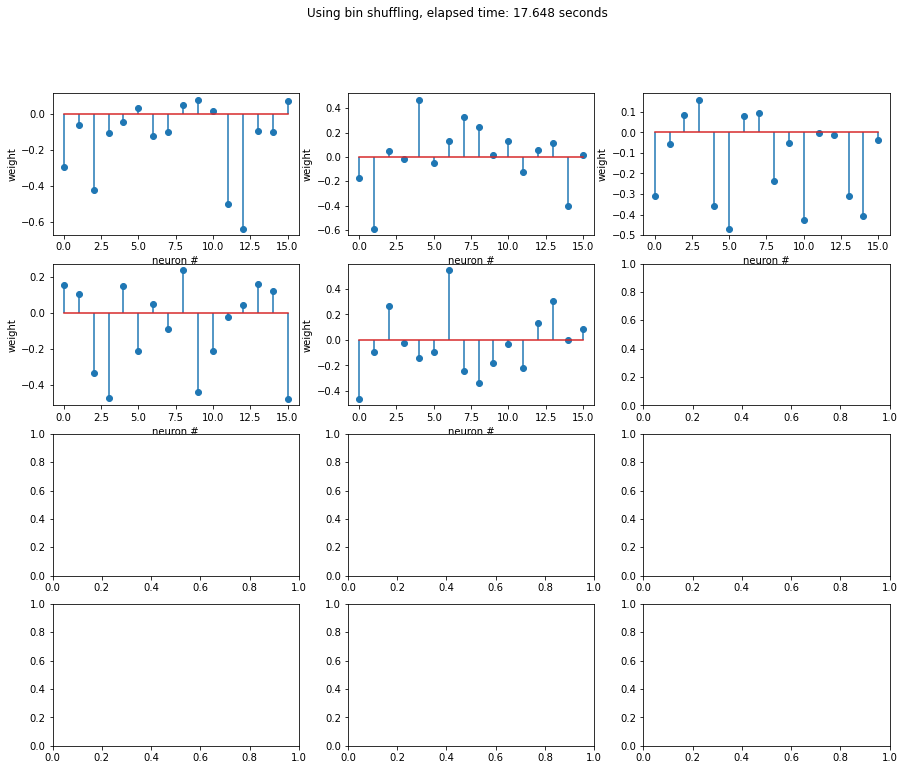

In [6]:
# using simple bin shuffling for computing null distribution
nshu = 1000 # defines number of controls to run (i.e., number of elements in null hypothesis distribution)
percentile = 99.5 # defines which percentile of control distribution will be used as significance threshold
t0 = time.time()
patterns,significance,zactmat = assembly.runPatterns(actmat,nullhyp='bin',nshu=nshu,percentile=percentile)
tf = np.round(1000*(time.time()-t0))/1000

fig, axs = plt.subplots(4,3, figsize=(15, 12))
axs = axs.ravel()

for (pi,pattern) in enumerate(patterns):
        axs[pi].stem(pattern)
        axs[pi].set_xlabel('neuron #')
        axs[pi].set_ylabel('weight')
fig.suptitle('Using bin shuffling, elapsed time: '+str(tf)+' seconds')

# circular shuffling as null distribution

Text(0.5, 0.98, 'Using circular shuffling, elapsed time: 3.024 seconds')

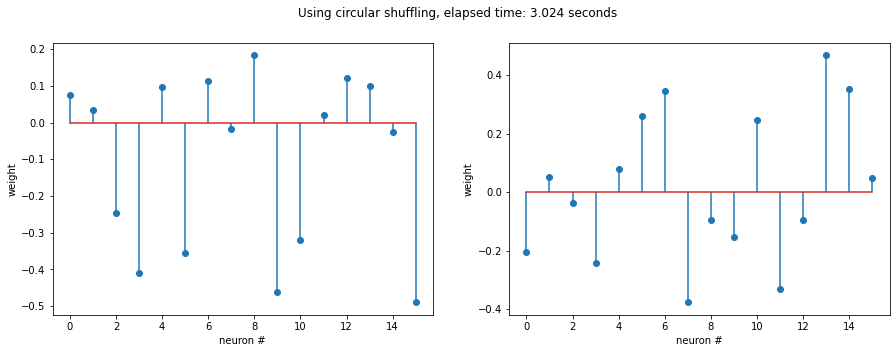

In [7]:
# using circular shuffling for computing null distribution (MUST USE IT IF YOU HAVE STRONG AUTOCORRELATIONS)
nshu = 1000 # defines number of controls to run (i.e., number of elements in null hypothesis distribution)
percentile = 99.5 # defines which percentile of control distribution will be used as significance threshold
t0 = time.time()
patterns,significance,zactmat = assembly.runPatterns(actmat,nullhyp='circ',nshu=nshu,percentile=percentile)
tf = np.round(1000*(time.time()-t0))/1000

plt.figure(figsize=(15,5))
for (pi,pattern) in enumerate(patterns):
        plt.subplot(1,len(patterns),1+pi)
        plt.stem(pattern)
        plt.xlabel('neuron #')
        plt.ylabel('weight')
plt.suptitle('Using circular shuffling, elapsed time: '+str(tf)+' seconds')

# plot all trials

In [8]:
# MP distribution
patterns,significance,zactmat = assembly.runPatterns(actmat,nullhyp='mp')
assemblyAct = assembly.computeAssemblyActivity(patterns,zactmat)

# parameters for shuffling
#nshu = 1000
#percentile = 99.5

# bin shuffling
#patterns,significance,zactmat = assembly.runPatterns(actmat,nullhyp='bin',nshu=nshu,percentile=percentile)

# circular shuffling
#patterns,significance,zactmat = assembly.runPatterns(actmat,nullhyp='circ',nshu=nshu,percentile=percentile)

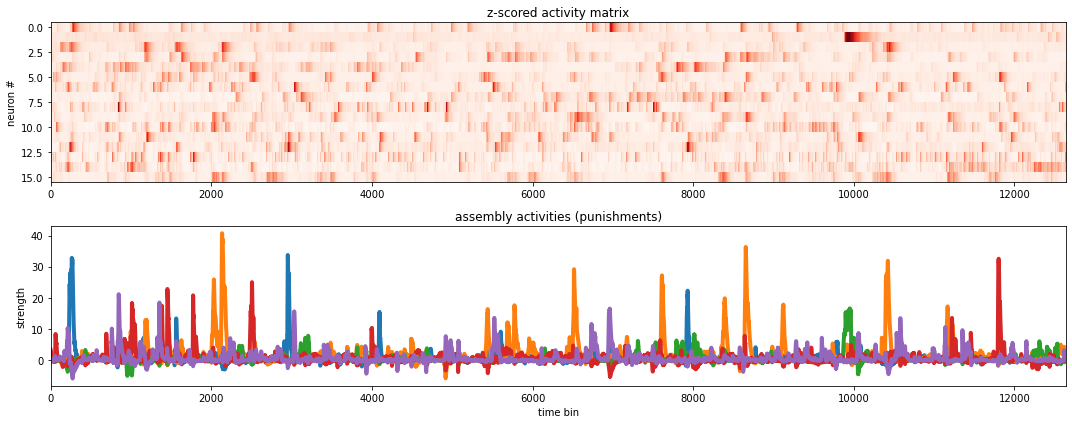

In [9]:
# plot ALL TRIALS: z-scored activity matrix
plt.figure(figsize=(15,6))
s1 = plt.subplot(211)
plt.imshow(zactmat,cmap='Reds',interpolation='nearest',aspect='auto')
plt.title('z-scored activity matrix')
plt.ylabel('neuron #')

# plot assemblies activities
plt.subplot(212,sharex=s1)
plt.plot(assemblyAct.T,linewidth=4)
plt.title('assembly activities (punishments)')
plt.xlabel('time bin')
plt.ylabel('strength')
plt.tight_layout()

# Note that the peaks of assembly activity correspond to co-activations of the corresponding assembly members

# all trials

In [10]:
# check which trials are punishments:
np.where(trials_is_reward==0)

(array([  1,   3,   4,   5,   7,  11,  12,  13,  14,  17,  18,  22,  23,
         27,  28,  30,  32,  34,  35,  38,  39,  40,  42,  47,  48,  50,
         53,  55,  57,  58,  59,  61,  62,  67,  71,  73,  75,  77,  80,
         84,  85,  87,  88,  89,  90,  92,  97,  99, 101, 102, 103, 105,
        106, 107, 108, 111]),)

In [11]:
# check which trials are rewards:
np.where(trials_is_reward==1)

(array([  0,   2,   6,   8,   9,  10,  15,  16,  19,  20,  21,  24,  25,
         26,  29,  31,  33,  36,  37,  41,  43,  44,  45,  46,  49,  51,
         52,  54,  56,  60,  63,  64,  65,  66,  68,  69,  70,  72,  74,
         76,  78,  79,  81,  82,  83,  86,  91,  93,  94,  95,  96,  98,
        100, 104, 109, 110]),)

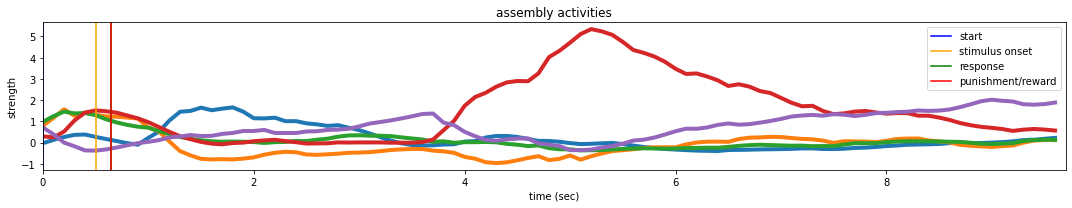

In [12]:
# plot specific trial
idx = 20 # trial number

actmat = np.transpose(channels_array) # [n_cells, n_timepoints]
patterns,significance,zactmat = assembly.runPatterns(actmat,nullhyp='mp')
assemblyAct = assembly.computeAssemblyActivity(patterns,zactmat)

# upper and lower bounds of trial
lower_bound = np.min(np.where(time_array>=new_start[idx]))
upper_bound = np.max(np.where(time_array<=new_end[idx]))

# change x-axis to time in sec
c = np.arange(0, len(assemblyAct.T[lower_bound:upper_bound]))
x = np.arange(c.size) * sampling_rate

# plot assemblies activities for trial
plt.figure(figsize=(15,3))
plt.plot(x, assemblyAct.T[lower_bound:upper_bound],linewidth=4)

# plot vertical lines for timepoints in trial
plt.axvline(x=new_start[idx] - new_start[idx], color='b', label='start')
plt.axvline(x=trials_stimulus_on[idx] - new_start[idx], color='orange', label='stimulus onset') 
plt.axvline(x=trials_response[idx] - new_start[idx], color='g', label='response') 
plt.axvline(x=trials_response[idx] - new_start[idx], color='r', label='punishment/reward') 
    
plt.title('assembly activities')
plt.xlabel('time (sec)')
plt.ylabel('strength')
plt.xlim(0,len(assemblyAct.T[lower_bound:upper_bound])*sampling_rate)
plt.legend()
plt.tight_layout()

# average across punishment/reward trials for one session

In [13]:
actmat = np.transpose(channels_array) # [n_cells, n_timepoints]
patterns,significance,zactmat = assembly.runPatterns(actmat,nullhyp='mp')
assemblyAct = assembly.computeAssemblyActivity(patterns,zactmat)

# fix at response timepoint +/- some timepoints
# set threshold for minimum time points before response
thr = 1.5
n_before_resp = 20
n_after_resp = 20
n_timepoints = n_before_resp+ n_after_resp

selected_trials = ((trials_response[0:-1] - new_start[0:-1])>thr) * 1
n_trials = np.sum(selected_trials)

assemblyAct_response_trials_pun = []
assemblyAct_response_trials_rew = []

# punishment trials
for i in range(len(new_start)-1):
    if selected_trials[i]==1:
        # only punishment trials
            if trials_is_reward[i]==0:
                resp_timepoint = int(trials_response[i]/ sampling_rate)
                x = assemblyAct.T[resp_timepoint-n_before_resp:resp_timepoint+n_after_resp,:]
                assemblyAct_response_trials_pun.append(x)
        
# reward trials
for i in range(len(new_start)-1):
    if selected_trials[i]==1:
        # only reward trials
            if trials_is_reward[i]==1:
                resp_timepoint = int(trials_response[i]/ sampling_rate)
                x = assemblyAct.T[resp_timepoint-n_before_resp:resp_timepoint+n_after_resp,:]
                assemblyAct_response_trials_rew.append(x)
    
assemblyAct_response_punishment = np.mean(assemblyAct_response_trials_pun, axis=0)
assemblyAct_response_reward = np.mean(assemblyAct_response_trials_rew, axis=0)

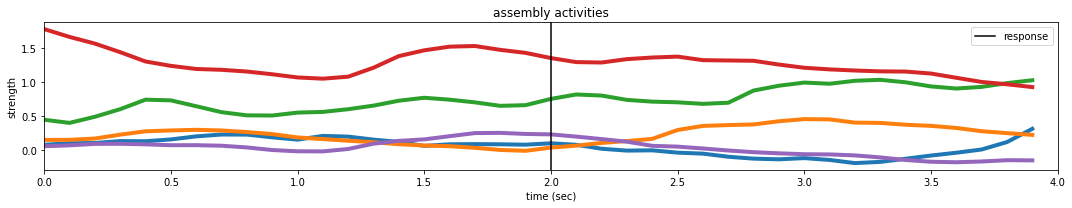

In [14]:
### punishment
# change x-axis to time in sec
c = np.arange(0, len(assemblyAct_response_punishment))
x = np.arange(c.size) * sampling_rate

# plot assemblies activities for trial
plt.figure(figsize=(15,3))
plt.plot(x, assemblyAct_response_punishment,linewidth=4)

# plot vertical lines for timepoints in trial
plt.axvline(x=n_before_resp*sampling_rate, color='k', label="response")
    
plt.title('assembly activities')
plt.xlabel('time (sec)')
plt.ylabel('strength')
plt.xlim(0,len(assemblyAct_response_punishment)*sampling_rate)
plt.legend()
plt.tight_layout()

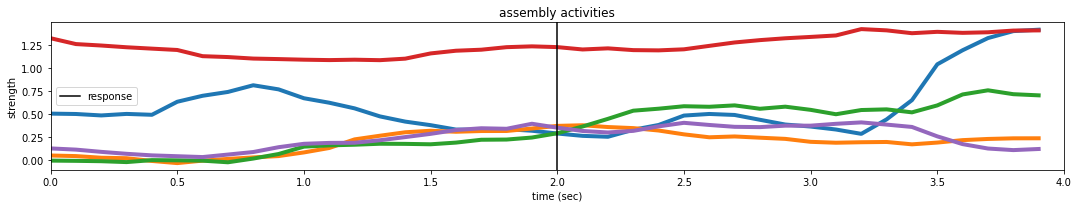

In [15]:
### reward
# change x-axis to time in sec
c = np.arange(0, len(assemblyAct_response_reward))
x = np.arange(c.size) * sampling_rate

# plot assemblies activities for trial
plt.figure(figsize=(15,3))
plt.plot(x, assemblyAct_response_reward,linewidth=4)

# plot vertical lines for timepoints in trial
plt.axvline(x=n_before_resp*sampling_rate, color='k', label="response")
    
plt.title('assembly activities')
plt.xlabel('time (sec)')
plt.ylabel('strength')
plt.xlim(0,len(assemblyAct_response_reward)*sampling_rate)
plt.legend()
plt.tight_layout()

# plot 100 time bins of simulation

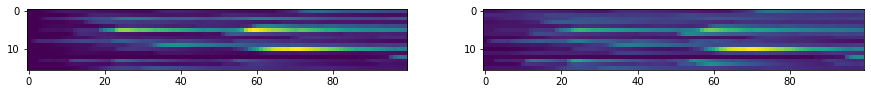

In [16]:
# plot first 100 time bins of simulation
plt.figure(figsize=(15,6))
s1 = plt.subplot(121)
plt.imshow(actmat[:,0:100])

# plot first 100 time bins of simulation (after z-scoring)
plt.subplot(122,sharex=s1)
plt.imshow(zactmat[:,0:100])

# save cells assemblies matrix (patterns)

In [17]:
# saving as pickle file
output_filename = "assemblies_activity/matrices/assemblies_matrix_{0}.pkl".format(session)
with open(os.path.join(animal_folder_name,output_filename), 'wb') as fp:
    pickle.dump(patterns, fp, protocol=pickle.HIGHEST_PROTOCOL)